In [1]:
##########################################IMPORTS##################################
import glob
import uproot as up
import awkward as ak
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import tqdm as tqdm
import multiprocessing as mp
import functools
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from operator import add
from matplotlib import rcParams
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [2]:
#######################################CONFIGURATION##################################

pd.options.mode.chained_assignment = None
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=32, 
                        inter_op_parallelism_threads=32, 
                        allow_soft_placement=True)

session = tf.compat.v1.Session(config=config)

2022-04-21 14:05:02.418072: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-21 14:05:02.441310: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/grid.cern.ch/centos7-umd4-wn-4.0.5-1_191112/lib64:/cvmfs/grid.cern.ch/centos7-umd4-wn-4.0.5-1_191112/lib:/cvmfs/grid.cern.ch/centos7-umd4-wn-4.0.5-1_191112/usr/lib64:/cvmfs/grid.cern.ch/centos7-umd4-wn-4.0.5-1_191112/usr/lib
2022-04-21 14:05:02.441335: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installe

In [3]:
#################################DataAquisitionAndWrangling#####################

def data_decay(file):
    """
    Function to open up and flatten root files
    """
    
    tfile= up.open(file)
    events=tfile["Events"]
    
    area=np.array(events["pulsesODHG.pulseArea_phd"])
    area=area.flatten()
    
    truth = tfile['RQMCTruth']
    pp = np.array(truth['mcTruthEvent./mcTruthEvent.parentParticle'])
    pp=pp.flatten()
    
    coincidence=np.array(events["pulsesODHG.coincidence"])
    coincidence=coincidence.flatten()
    
    
    peak_time=np.array(events["pulsesODHG.peakTime_ns"])
    peak_time=peak_time.flatten()
       

    peak_amp=np.array(events["pulsesODHG.peakAmp"])
    peak_amp=peak_amp.flatten()
    
    
    t_25=np.array(events["pulsesODHG.areaFractionTime25_ns"])
    t_25=t_25.flatten()
    
    
    t_50=np.array(events["pulsesODHG.areaFractionTime50_ns"])
    t_50=t_50.flatten()
    
    
    t_75=np.array(events["pulsesODHG.areaFractionTime75_ns"])
    t_75=t_75.flatten()
    
    
    start=np.array(events["pulsesODHG.pulseStartTime_ns"])
    start=start.flatten()
    
    
    end=np.array(events["pulsesODHG.pulseEndTime_ns"])
    end=end.flatten()
    
    
    length=end-start
    area_time=t_75/area
    
    return [area,coincidence,peak_time,peak_amp,t_25,t_50,t_75,length,area_time,pp]

def data():
    """
    Loops over all root files and turns data into pandas arrays
    """
    columns={'Pulse Area' : [], 'Coincidence' : [], 'Peak Time' : [],'Peak Amp' : [], 
             '25% time' : [], '50% time' : [],'75% time' : [], 'Pulse Time' : [], 'time/area' : [],'tag' : []}
    columns_exp=['Pulse Area','Coincidence','Peak Time','Peak Amp','25% time',
             '50% time', '75% time', 'Pulse Time', 'time/area']
    files = glob.glob('/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.14_DER_9.1.0_LZAP_5.4.1/od_internals/lzap_output/*')
    with mp.Pool(30) as pool: # uses pool multiprocessing for parallellisation
            internals_data = list(tqdm.tqdm(pool.imap(functools.partial(data_decay),files),total=3000))#uses tqdm to time aquisition
    internals_data=pd.DataFrame(np.concatenate(internals_data,axis=1).T.tolist(),columns=columns)
    internals_data=(((internals_data.explode(columns_exp)).reset_index().dropna())).drop(columns='index')
    internals_data=internals_data[(internals_data["Pulse Area"] > 5)&(internals_data['Coincidence'] >1)]
    
    files = glob.glob('/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.14_DER_9.1.0_LZAP_5.4.1/gdls_neutrons/lzap_output/*')
    with mp.Pool(30) as pool:
            neutron_data = list(tqdm.tqdm(pool.imap(functools.partial(data_decay),files),total=1962))
    neutron_data=pd.DataFrame(np.concatenate(neutron_data,axis=1).T.tolist(),columns=columns)
    neutron_data=(((neutron_data.explode(columns_exp)).reset_index().dropna())).drop(columns='index')
    neutron_data=neutron_data[(neutron_data["Pulse Area"] > 5)&(neutron_data['Coincidence'] >1)]
    
    files = glob.glob('/hdfs/user/ak18773/od_simulations/BACCARAT_6.2.14_DER_9.1.0_LZAP_5.4.1/scinttank_rockgamma_all/lzap_output/*')
    with mp.Pool(30) as pool:
            rockgamma_data = list(tqdm.tqdm(pool.imap(functools.partial(data_decay),files),total=116))
    rockgamma_data=pd.DataFrame(np.concatenate(rockgamma_data,axis=1).T.tolist(),columns=columns)
    rockgamma_data=(((rockgamma_data.explode(columns_exp)).reset_index().dropna())).drop(columns='index')
    rockgamma_data=rockgamma_data[(rockgamma_data["Pulse Area"] > 5)&(rockgamma_data['Coincidence'] >1)]
    
    return internals_data,neutron_data,rockgamma_data

def separate(internals_data,neutron_data,rockgamma_data):
    """
    Separates dataframes into decay type and chain
    """
    
    Th232_chain_tag=['Th232','Ra228','Ac228','Th228','Ra224','Rn220',
             'Po216','Po212','Bi212','Pb212','Pb208','Ti208']

    U238_chain_tag=['U238','Th234','Pa234','U234','Th230','Ra226',
                'Rn222','Po218','Pb214','At218','Bi214','Ti210','Po214',
                'Pb210','Hg206','Bi210','Ti206','Po210','Pb206']

    electrons_tag=['Th234','Pa234','Bi214','Ti210','Pb210','Bi210',
           'Ti206','Ra228','Ac228','Pb212','Bi212','Ti208']

    alphas_tag=['U238','U234','Th230','Ra226','Rn222','Po218','At218',
        'Bi214','Po214','Pb210','Bi210','Po210','Th232','Th228',
        'Ra224','Rn220','Po216','Bi212','Po212']


    Th232_chain=internals_data[internals_data['tag'].isin(Th232_chain_tag)]
    U238_chain=internals_data[internals_data['tag'].isin(U238_chain_tag)]
    U238_Th232_chain=pd.concat([Th232_chain,U238_chain])
    reminder=(pd.DataFrame(internals_data).merge(pd.DataFrame(U238_Th232_chain), how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']).drop(columns=['_merge']) 
    reminder=reminder[reminder['tag'] != "Gd152"]
    U238_chain=U238_chain.drop(columns=["tag"])
    U238_chain['tag']='U238'
    
    Th232_chain=Th232_chain.drop(columns=["tag"])
    Th232_chain['tag']='Th232'

    electrons=internals_data[internals_data['tag'].isin(electrons_tag)]
    alphas=internals_data[internals_data['tag'].isin(alphas_tag)]
    electons_alphas=pd.concat([electrons,alphas])
    reminder_type=(pd.DataFrame(internals_data).merge(pd.DataFrame(electons_alphas), how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']).drop(columns=['_merge']) 
    reminder_type=reminder_type[reminder_type['tag'] != "Gd152"]
    electrons=electrons.drop(columns=["tag"])
    alphas=alphas.drop(columns=["tag"])
    electrons['tag']='electron'
    alphas['tag']='alpha'
    return Th232_chain,U238_chain,reminder, electrons, alphas,reminder_type


In [4]:
##################################DataVisualisation#####################################
def plot(Data1,Data2,Data3,Data4,Data,label1,label2,label3,label4):
    """
    Plots various aspects of dataframes
    """

    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    axes[0,0].scatter(Data1['Pulse Area'],Data1['Coincidence'],label=label1,alpha=0.2)

    axes[0,0].set_xlabel("Area")
    axes[0,0].set_ylabel("coincidence")
    axes[0,0].legend(loc='lower right')
    axes[0,0].set_title("pulse area against coincidence")



    axes[0,1].scatter(Data2['Pulse Area'],Data2['Coincidence'],label=label2,alpha=0.2,color="orange")

    axes[0,1].set_xlabel("Area")
    axes[0,1].set_ylabel("coincidence")
    axes[0,1].legend(loc='lower right')
    axes[0,1].set_title("pulse area against coincidence")


    axes[1,0].scatter(Data3['Pulse Area'],Data3['Coincidence'],label=label3,alpha=0.2,color="r")
    axes[1,0].set_xlabel("Area")
    axes[1,0].set_ylabel("coincidence")
    axes[1,0].legend(loc='lower right')
    axes[1,0].set_title("pulse area against coincidence")

    axes[1,1].scatter(Data4['Pulse Area'],Data4['Coincidence'],label=label4,alpha=0.2)
    axes[1,1].set_xlabel("Pulse Area")
    axes[1,1].set_ylabel("Coincidence")
    axes[1,1].legend(loc='lower right')
    axes[1,1].set_title("area against coincidence")
    plt.show()

    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    axes[0,0].scatter(Data1['Pulse Area'],Data1['Peak Amp'],label=label1,alpha=0.3)
    axes[0,0].scatter(Data2['Pulse Area'],Data2['Peak Amp'],label=label2,alpha=0.3)
    axes[0,0].scatter(Data3['Pulse Area'],Data3['Peak Amp'],label=label3,alpha=0.3)
    axes[0,0].scatter(Data4['Pulse Area'],Data4['Peak Amp'],label=label4,alpha=0.3)
    axes[0,0].set_xlabel("Pulse area")
    axes[0,0].set_ylabel("peak current")
    axes[0,0].legend(loc='upper right')
    axes[0,0].set_title("pulse area vs peak current")


    axes[0,1].scatter(Data1['Coincidence'],Data1['Peak Amp'],label=label1,alpha=0.2)
    axes[0,1].scatter(Data2['Coincidence'],Data2['Peak Amp'],label=label2,alpha=0.2)
    axes[0,1].scatter(Data3['Coincidence'],Data3['Peak Amp'],label=label3,alpha=0.2)
    axes[0,1].scatter(Data4['Coincidence'],Data4['Peak Amp'],label=label4,alpha=0.2)
    axes[0,1].set_xlabel("Coincidence")
    axes[0,1].set_ylabel("peak current")
    axes[0,1].legend(loc='upper right')
    axes[0,1].set_title("coincidence vs peak current")

    axes[1,0].hist(Data1['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500], label=label1)
    axes[1,0].hist(Data2['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label=label2)
    axes[1,0].hist(Data3['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label=label3)
    axes[1,0].hist(Data4['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label=label4)
    axes[1,0].set_xlabel("Pulse Area")
    axes[1,0].legend(loc='upper right')
    axes[1,0].set_title("Pulse Area")
    
    
    
    axes[1,1].hist(Data1['Pulse Time'], alpha = 0.7,bins=55,label=label1)
    axes[1,1].hist(Data2['Pulse Time'], alpha = 0.7,bins=55,label=label2)
    axes[1,1].hist(Data3['Pulse Time'], alpha = 0.7,bins=55,label=label3)
    axes[1,1].hist(Data4['Pulse Time'], alpha = 0.7,bins=55,label=label4)
    axes[1,1].set_xlabel("Pulse Time")
    axes[1,1].legend(loc='upper right')
    axes[1,1].set_title("Pulse Time")
    plt.show()

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes[0,0].hist(Data1['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500], label=label1)
    axes[0,0].hist(Data2['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label=label2)
    axes[0,0].hist(Data3['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label=label3)
    axes[0,0].hist(Data4['Pulse Area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,500],label=label4)

    axes[0,1].hist(Data1['Coincidence'],histtype='step',bins=100,stacked=True ,density=True, label=label1)
    axes[0,1].hist(Data2['Coincidence'],histtype='step',bins=100,stacked=True ,density=True,label=label2)
    axes[0,1].hist(Data3['Coincidence'],histtype='step',bins=100,stacked=True ,density=True,label=label3)
    axes[0,1].hist(Data4['Coincidence'],histtype='step',bins=100,stacked=True ,density=True,label=label4)
                         
    axes[0,2].hist(Data1['Peak Time'],bins=30,stacked=True ,density=True,range=[0,200], label=label1)
    axes[0,2].hist(Data2['Peak Time'],bins=30,stacked=True ,density=True,range=[0,200],label=label2)
    axes[0,2].hist(Data3['Peak Time'],bins=30,stacked=True ,density=True,range=[0,200],label=label3)
    axes[0,2].hist(Data4['Peak Time'],bins=30,stacked=True ,density=True,range=[0,200],label=label4)
                         
                         
    axes[1,0].hist(Data1['Peak Amp'],histtype='step',bins=200,stacked=True ,density=True, range=[0,8],label=label1)
    axes[1,0].hist(Data2['Peak Amp'],histtype='step',bins=200,stacked=True ,density=True,range=[0,8],label=label2)
    axes[1,0].hist(Data3['Peak Amp'],histtype='step',bins=200,stacked=True ,density=True,range=[0,8],label=label3)
    axes[1,0].hist(Data4['Peak Amp'],histtype='step',bins=200,stacked=True ,density=True,range=[0,8],label=label4)
                         
                         
    axes[1,1].hist(Data1['25% time'],bins=30,stacked=True ,density=True, range=[0,200],label=label1)
    axes[1,1].hist(Data2['25% time'],bins=30,stacked=True ,density=True,range=[0,200],label=label2)
    axes[1,1].hist(Data3['25% time'],bins=30,stacked=True ,density=True,range=[0,200],label=label3)
    axes[1,1].hist(Data4['25% time'],bins=30,stacked=True ,density=True,range=[0,200],label=label4)
    
    axes[1,2].hist(Data1['Pulse Time'],bins=100,stacked=True ,density=True,label=label1)
    axes[1,2].hist(Data2['Pulse Time'],bins=100,stacked=True ,density=True,label=label2)
    axes[1,2].hist(Data3['Pulse Time'],bins=100,stacked=True ,density=True,label=label3)
    axes[1,2].hist(Data4['Pulse Time'],bins=100,stacked=True ,density=True,label=label4)
                         
    axes[2,0].hist(Data1['75% time'],bins=30,stacked=True ,density=True,range=[0,250], label=label1)
    axes[2,0].hist(Data2['75% time'],bins=30,stacked=True ,density=True,range=[0,250],label=label2)
    axes[2,0].hist(Data3['75% time'],bins=30,stacked=True ,density=True,range=[0,250],label=label3)
    axes[2,0].hist(Data4['75% time'],bins=30,stacked=True ,density=True,range=[0,250],label=label4)
                         
                         
    axes[2,1].hist(Data1['50% time'],bins=30,stacked=True ,density=True,range=[0,200], label=label1)
    axes[2,1].hist(Data2['50% time'],bins=30,stacked=True ,density=True,range=[0,200],label=label2)
    axes[2,1].hist(Data3['50% time'],bins=30,stacked=True ,density=True,range=[0,200],label=label3)
    axes[2,1].hist(Data4['50% time'],bins=30,stacked=True ,density=True,range=[0,200],label=label4)

    axes[2,2].hist(Data1['time/area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,3], label=label1)
    axes[2,2].hist(Data2['time/area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,3],label=label2)
    axes[2,2].hist(Data3['time/area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,3],label=label3)
    axes[2,2].hist(Data4['time/area'],histtype='step',bins=200,stacked=True ,density=True,range=[0,3],label=label4)
    plt.legend()
    plt.show()



In [5]:
########################################CutMethod###################################

def cut_metrics(data_guess,Data_real,Data_withtag,decay):
    """
    Metrics used to determine best cuts
    """
    not_guess_data = (Data_withtag.merge(data_guess, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']).drop(columns=['_merge'])   
            
        
    tp=len(data_guess[data_guess['tag'] == decay ])
    tn=len(not_guess_data[not_guess_data['tag'] != decay])
    fp=len(data_guess[data_guess['tag'] != decay ])
    fn=len(not_guess_data[not_guess_data['tag'] == decay])
        
        
            
    accuracy=(tp+tn)/(tp+tn+fp+fn)
          
    if (tp+fn) == 0:
            recall=0 
    else:
        recall=(tp)/(tp+fn)

    precision=(tp)/(tp+fp)
    if (recall+precision) == 0:
        F=0
    else:
        F=(2*recall*precision)/(recall+precision)
    if (tn+fp) ==0:
        specificity=0
    else:
        specificity=(tn)/(tn+fp)
    return accuracy,recall,precision,F,specificity
        
        
def area_cut(start_point,Data_withtag,decay):
    """
    Internal cut function to be looped over
    """
    
    area_range_max=np.arange(start_point,500,5)#loops from a given start point through to end
    
    accuracy_list=[]
    recall_list=[]
    precision_list=[]
    F_list=[]
    specificity_list=[]
    minval=[]
    maxval=[]
    for end_point in area_range_max:
        
            data_guess=Data_withtag[(Data_withtag["Pulse Area"] > start_point) & (Data_withtag["Pulse Area"] < end_point)]    
        
        
            not_guess_data = (Data_withtag.merge(data_guess, how = 'outer' ,indicator=True).loc[lambda x : x['_merge']=='left_only']).drop(columns=['_merge'])   
           
        
            tp=len(data_guess[data_guess['tag'] == decay ])
            tn=len(not_guess_data[not_guess_data['tag'] != decay])
            fp=len(data_guess[data_guess['tag'] != decay ])
            fn=len(not_guess_data[not_guess_data['tag'] == decay])
        
            
            accuracy=(tp+tn)/(tp+tn+fp+fn)
          
            if (tp+fn) == 0:
                recall=0 
            else:
                recall=(tp)/(tp+fn)
            if (tp+fp) ==0:
                precision =0
            else:
                precision=(tp)/(tp+fp)
            if (recall+precision) ==0:
                F=0
            else:
                F=(2*recall*precision)/(recall+precision)
            if (tn+fp) ==0:
                specificity=0
            else:
                specificity=(tn)/(tn+fp)
            accuracy_list.append(accuracy)
            recall_list.append(recall)
            precision_list.append(precision)
            F_list.append(F)
            specificity_list.append(specificity)
            minval.append(start_point)
            maxval.append(end_point)
    return [minval,maxval,accuracy_list,recall_list,precision_list,F_list,specificity_list]

def auto_cut(set1,set2,set3,set4,combined,decay1,decay2,decay3,decay4):
    """
    Cut method implimentation
    """
    columns=["Pulse Area","Coincidence", "Peak Time", "Peak Amp", "25% time",'Pulse Time', "75% time", "50% time","time/area"]
    info_columns={'minval' : [],'maxval' : [],'accuracy' : [], 'recall' : [], 'precision' : [], 'F1 score' : [], 'specificity' :[]}
    
    area_range_min=np.arange(0,500,5)
    
    with mp.Pool(40) as pool:#parallel processing of specific cuts
         set1_data=list(tqdm.tqdm(pool.imap(functools.partial(area_cut,Data_withtag=combined,decay=decay1),area_range_min),total=100))
    info_set1=pd.DataFrame(np.concatenate(set1_data,axis=1).T.tolist(),columns=info_columns)
           
    
    with mp.Pool(40) as pool:
         set2_data=list(tqdm.tqdm(pool.imap(functools.partial(area_cut,Data_withtag=combined,decay=decay2),area_range_min),total=100))
    info_set2=pd.DataFrame(np.concatenate(set2_data,axis=1).T.tolist(),columns=info_columns)
    
    
    
    
    with mp.Pool(40) as pool:
         set3_data=list(tqdm.tqdm(pool.imap(functools.partial(area_cut,Data_withtag=combined,decay=decay3),area_range_min),total=100))
    info_set3=pd.DataFrame(np.concatenate(set3_data,axis=1).T.tolist(),columns=info_columns)       
    
    
    
    with mp.Pool(40) as pool:
         set4_data=list(tqdm.tqdm(pool.imap(functools.partial(area_cut,Data_withtag=combined,decay=decay4),area_range_min),total=100))
    info_set4=pd.DataFrame(np.concatenate(set4_data,axis=1).T.tolist(),columns=info_columns)
    
    #best cut is determined by F1 score
    max_set1=info_set1[info_set1['F1 score'] == info_set1['F1 score'].max()]
    max_set2=info_set2[info_set2['F1 score'] == info_set2['F1 score'].max()]
    max_set3=info_set3[info_set3['F1 score'] == info_set3['F1 score'].max()]
    max_set4=info_set4[info_set4['F1 score'] == info_set4['F1 score'].max()]       
    
    info=[info_set1,info_set2,info_set3,info_set4]

    #Cut with best F1 score is then selected   
   
    set1_data_guess=combined[(combined["Pulse Area"] > max_set1['minval'].max()) & (combined["Pulse Area"] < max_set1['maxval'].max())]
    set2_data_guess=combined[(combined["Pulse Area"] > max_set2['minval'].max()) & (combined["Pulse Area"] < max_set2['maxval'].max())]
    set3_data_guess=combined[(combined["Pulse Area"] > max_set3['minval'].max()) & (combined["Pulse Area"] < max_set3['maxval'].max())]
    set4_data_guess=combined[((combined["Pulse Area"] > max_set4['minval'].max()) & (combined["Pulse Area"] < max_set4['maxval'].max()))]
    
    


    #metrics for this new cut is then determined
    set1_accuracy,set1_recall,set1_precision,set1_F,set1_specificity=cut_metrics(set1_data_guess,set1,combined,decay1)
    set2_accuracy,set2_recall,set2_precision,set2_F,set2_specificity=cut_metrics(set2_data_guess,set2,combined,decay2)
    set3_accuracy,set3_recall,set3_precision,set3_F,set3_specificity=cut_metrics(set3_data_guess,set3,combined,decay3)
    set4_accuracy,set4_recall,set4_precision,set4_F,set4_specificity=cut_metrics(set4_data_guess,set4,combined,decay4)
    data=[set1_data_guess,set2_data_guess,set3_data_guess,set4_data_guess]
    #and added to array
    columns={'sample' : [], 'accuracy' : [], 'recall' : [], 'precision' : [], 'F1 score' : [], 'specificity' : []}
    metrics=pd.DataFrame(columns=columns)
    metrics['sample']=[decay1,decay2,decay3,decay4]
    metrics['accuracy']=[set1_accuracy,set2_accuracy,set3_accuracy,set4_accuracy]
    metrics['recall']=[set1_recall,set2_recall,set3_recall,set4_recall]
    metrics['precision']=[set1_precision,set2_precision,set3_precision,set4_precision]
    metrics['F1 score']=[set1_F,set2_F,set3_F,set4_F]
    metrics['specificity']=[set1_specificity,set2_specificity,set3_specificity,set4_specificity]
    print(metrics)



    
    return metrics,data,info
    

In [22]:
#############################Statistical method################################

def PDE(decaytype,background):
    """
    generates likelihood histogram
    """
    bins = np.linspace(0,200,1000)
    
    signal = np.histogram(decaytype['Pulse Area'], bins, density=False)#determines signal
    signal = list(signal)
    signal[0] = [i/len(electrons['Pulse Area']) for i in signal[0]]
    
    drop = decaytype['tag']
    dropvalues = ['{}'.format(drop)]



    background = background[background.tag.isin(dropvalues) == False]#determines background
    background = np.histogram(background['Pulse Area'],bins, density=False)
    background = list(background)
    background[0] = [i/len(decaytype['Pulse Area']) for i in background[0]]
    
    L = np.divide(signal[0],(np.add(signal[0] , background[0])))#finds likelihood
    centre = [ (y+x)/2 for x, y in zip(signal[1],signal[1][1:]) ] 
    
    return L,centre 

def NNE(input_number,input_array,outputarray):
    """
    maps new values to generated histogram to assign likelihood
    """
    
    mapped = list(zip(input_array,outputarray))
    NN = min(input_array, key=lambda x:abs(x-input_number))
    index = input_array.index(NN)
    output = mapped[index][1]
    
    return output
    
    
    
    
def pde_run(electrons,alphas,neutron_data,rockgamma_data,decay_type):
    """
    runs pde functions and plots discriminators
    """
    EL,Ecentre=PDE(electrons,decay_type)
    AL,Acentre=PDE(alphas,decay_type)
    NL,Ncentre=PDE(neutron_data,decay_type)
    GL,Gcentre=PDE(rockgamma_data,decay_type)
           

                  
    plt.figure(figsize=(10,10))
    sns.set(font_scale=1.1)
    plt.plot(Ecentre,EL,label='electrons',color='c')
    plt.plot(Acentre,AL,label='alpha',color='y')
    plt.plot(Ncentre,NL,label='neutrons',color='r')
    plt.plot(Gcentre,GL,label='RockGamma',color='b')

    plt.xlabel("Pulse Area")
    plt.ylabel("Probability")
    plt.title("Probability Distribution")
    plt.legend()
    plt.show()

    pde_df=decay_type.copy()
    
    pde_df.drop(pde_df.columns.difference(['Pulse Area','tag']), 1, inplace=True)


    pde_df['alpha prob'] = tqdm.tqdm(pde_df.apply(lambda row: NNE(row['Pulse Area'],Acentre,AL),axis=1),total=708046)
    pde_df['electron prob'] = tqdm.tqdm(pde_df.apply(lambda row: NNE(row['Pulse Area'],Ecentre,EL),axis=1),total=708046)
    pde_df['gamma prob'] = tqdm.tqdm(pde_df.apply(lambda row: NNE(row['Pulse Area'],Gcentre,GL),axis=1),total=708046)
    pde_df['neutron prob'] = tqdm.tqdm(pde_df.apply(lambda row: NNE(row['Pulse Area'],Ncentre,NL),axis=1),total=708046)


    one_hot = pd.get_dummies(pde_df['tag'])
    pde_df=pd.concat([pde_df, one_hot], axis=1)

    categories = ['alpha','electron','RockGamma','neutron']

    Afpr, Atpr, Athresholds = roc_curve(pde_df['alpha'], pde_df['alpha prob'])
    Bfpr, Btpr, Bthresholds = roc_curve(pde_df['electron'], pde_df['electron prob'])
    Nfpr, Ntpr, Nthresholds = roc_curve(pde_df['neutron'], pde_df['neutron prob'])
    Rfpr, Rtpr, Rthresholds = roc_curve(pde_df['RockGamma'], pde_df['gamma prob'])

    plt.figure(figsize=(10,10))
    sns.set(font_scale=1.3)
    plt.plot(Afpr,Atpr,label='alpha vs background, AUC score:{:.3f} '.format(auc(Afpr,Atpr)), color = 'c')
    plt.plot(Bfpr,Btpr,label='electron vs background, AUC score:{:.3f}' .format(auc(Bfpr,Btpr)),color = 'y')
    plt.plot(Nfpr,Ntpr,label='neutron vs background, AUC score:{:.3f} ' .format(auc(Nfpr,Ntpr)),color = 'r')
    plt.plot(Rfpr,Rtpr,label='rockgamma vs background, AUC score:{:.3f} ' .format(auc(Rfpr,Rtpr)),color = 'b')
    plt.plot([0,1],[0,1], linestyle = '--', label = 'No classifier', color = 'm')


    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.legend()
    plt.show()
    plt.close()
    true_labels=np.asarray([pde_df['alpha'],pde_df['electron'],pde_df['RockGamma'],pde_df['neutron']])
    predicted_labels=np.asarray([pde_df['alpha prob'],pde_df['electron prob'],pde_df['gamma prob'],pde_df['neutron prob']])
    pde_metrics_list=[]
    
    for i in range (4):
        confusion=confusion_matrix(true_labels[i], discriminator(predicted_labels[i],0.2))
        pde_metrics=confusion_metrics(confusion)
        pde_metrics_list.append(pde_metrics)
    
    columns={'accuracy' : [], 'recall' : [], 'precision' : [], 'F1 score' : [], 'specificity' : []}
    pde_metrics=pd.DataFrame(np.asarray(pde_metrics_list),columns=columns)    
    pde_metrics['method']='Statistical'

    pde_metrics['sample']=categories   
    cm=confusion_matrix(true_labels.T.argmax(axis=1), predicted_labels.T.argmax(axis=1),normalize='true')


    sns.set(font_scale=1.3)
    sns.heatmap(cm,xticklabels=categories,yticklabels=categories, annot=True,fmt='.2%',cbar=False, cmap='Blues')
    plt.show()
    plt.close()


    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    sns.histplot(ax=ax[0,0],data=pde_df, x="alpha prob",hue='tag', element="poly", common_norm=False, stat="density")
    ax[0,0].set_title('Alpha Discriminator')
    sns.histplot(ax=ax[0,1],data=pde_df, x="electron prob",hue='tag', element="poly", common_norm=False, stat="density")
    ax[0,1].set_title('Electron Discriminator')
    sns.histplot(ax=ax[1,0],data=pde_df, x="neutron prob",hue='tag', element="poly", common_norm=False, stat="density")
    ax[1,0].set_title('Neutron Discriminator')
    sns.histplot(ax=ax[1,1],data=pde_df, x="gamma prob",hue='tag', element="poly", common_norm=False, stat="density")
    ax[1,1].set_title('Gamma Discriminator')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
    plt.show()
    plt.close()

    

    columns={'accuracy' : [], 'recall' : [], 'precision' : [], 'F1 score' : [], 'specificity' : []}
    pde_metrics=pd.DataFrame(pde_metrics_list,columns=columns)
    return pde_metrics,Afpr, Atpr,Bfpr, Btpr,Nfpr, Ntpr,Rfpr, Rtpr


In [7]:

##################################NeuralNetwork#############################

def binary_classifier(output_bias):
    """
    Binary classifier model
    """
    output_bias=tf.keras.initializers.Constant(output_bias)

    
    model = keras.Sequential([
    keras.layers.Dense(9,input_dim=9, activation='relu'),
    keras.layers.Dense(18, activation="relu"),
    keras.layers.Dense(18, activation="relu"),
    keras.layers.Dense(18, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid",bias_initializer=output_bias)])
    

    opt = tf.keras.optimizers.Adam(learning_rate = 0.005)
    
    model.compile(loss='binary_crossentropy',  metrics=['AUC',"binary_accuracy"], optimizer=opt)
    return model

def multiclassifier():
    """
    Multiclass model
    """
    
    output_bias=tf.keras.initializers.Constant()

    
    model = keras.Sequential([
    keras.layers.Dense(9,input_dim=9, activation='relu'),
    keras.layers.Dense(18, activation="relu"),
    keras.layers.Dense(18, activation="relu"),
    keras.layers.Dense(18, activation="relu"),
    keras.layers.Dense(4, activation="softmax")])
    

    opt = tf.keras.optimizers.Adam(learning_rate = 0.005)
    
    model.compile(loss='categorical_crossentropy',  metrics=['AUC',"categorical_accuracy"], optimizer=opt)
    return model



def preprocess(Data_withtag,sample1,sample2):
    """
    PreProcessing for binary classifier
    """
    
    features=Data_withtag[(Data_withtag['tag'] == sample1) | (Data_withtag['tag'] == sample2)]
    labels=Data_withtag[(Data_withtag['tag'] == sample1) | (Data_withtag['tag'] == sample2)]
    features=(features.iloc[:,0:9]).apply(pd.to_numeric)

    features=tf.keras.utils.normalize(features).squeeze()
    
    labels=labels.iloc[:,-1]
    labels = pd.get_dummies(data = labels, columns=[sample1],drop_first=True)
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.33, random_state=42)
    labels_train=np.asarray(labels_train).astype('float32').reshape((-1,1))
    labels_test=np.asarray(labels_test).astype('float32').reshape((-1,1))
    return features_train,features_test,labels_train,labels_test

def confusion_metrics(confusion_matrix):
    """
    Function to generate confusion matrix metrics
    """
    tp=confusion_matrix[0,0]
    fn=confusion_matrix[0,1]
    fp=confusion_matrix[1,0]
    tn=confusion_matrix[1,1]
    
    accuracy=(tp+tn)/(tp+fn+fp+tn)
    recall=(tp)/(tp+fn)
    precision=(tp)/(tp+fp)
    F1=(2*recall*precision)/(recall+precision)
    specificity=(tn)/(tn+fp)

    

    return accuracy,recall,precision,F1,specificity

def discriminator(probability,threshold):
    """
    discriminator for a given threshold
    """
    prediction=np.where(probability > threshold, 1, 0)
    return prediction

def binary_run(Data_withtag,sample1,sample2):
    """
    Function that processes and runs the binary model
    """
    
    stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=40)#callback to monitor progress
    features_train,features_test,labels_train,labels_test=preprocess(Data_withtag,sample1,sample2)
    train_label_df=pd.DataFrame(labels_train,columns=['tag'])
    pos=len(train_label_df[train_label_df['tag']==1])
    neg=len(train_label_df[train_label_df['tag']==0])
    total=len(train_label_df['tag'])
    initial_bias = np.log([pos/neg])#custom weights set
    weight_for_0 = (1 / neg) * (total / 2.0)
    weight_for_1 = (1 / pos) * (total / 2.0)

    class_weight = {0: weight_for_0, 1: weight_for_1}
    
    model=binary_classifier(output_bias=initial_bias)

    model.summary()
    history=model.fit(features_train, labels_train, epochs=400, batch_size=1024, verbose=1,validation_split=0.2, callbacks=[stop],class_weight=class_weight)

    proba = model.predict(features_test)

    
    return history,labels_test,proba

def multiclass(decay_type):
    """
    Processing and running of multiclass model
    """

    oversample = SMOTE()#oversampling to balence dataset
    stop = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=200)
    features=(decay_type.iloc[:,0:9]).apply(pd.to_numeric)
    features=tf.keras.utils.normalize(features).squeeze()
    labels=decay_type.iloc[:,-1]
    labels = pd.get_dummies(data = labels)
    features, labels= oversample.fit_resample(np.asarray(features), np.asarray(labels))

    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.33, random_state=42)
    labels_train=np.asarray(labels_train).astype('float32')
    labels_test=np.asarray(labels_test).astype('float32')

    model=multiclassifier()

    model.summary()
    history=model.fit(features_train, labels_train, epochs=400, batch_size=1024, verbose=1,validation_split=0.2, callbacks=[stop])
    proba = model.predict(features_test)
    return history, labels_test ,proba

In [19]:
internals_data,neutron_data,rockgamma_data=data()
Th232_chain,U238_chain,reminder, electrons, alphas,reminder_type=separate(internals_data,neutron_data,rockgamma_data)
decay_type=pd.concat([electrons,alphas,neutron_data,rockgamma_data],ignore_index=True)

100%|█████████████████████████████████████████| 116/116 [00:25<00:00,  4.54it/s]


In [ ]:
#############Additional Preprocess###################
info_df=(decay_type.iloc[:,0:9]).apply(pd.to_numeric)
info_df=tf.keras.utils.normalize(info_df).squeeze()

electron_df=(electrons.iloc[:,0:9]).apply(pd.to_numeric)
electron_df=tf.keras.utils.normalize(electron_df).squeeze()
electron_df['tag']='electron'
electron_df['tag'] = electron_df['tag'].astype("string")
alpha_df=(alphas.iloc[:,0:9]).apply(pd.to_numeric)
alpha_df=tf.keras.utils.normalize(alpha_df).squeeze()
alpha_df['tag']='alpha'
alpha_df['tag'] = alpha_df['tag'].astype("string")
neutron_df=(neutron_data.iloc[:,0:9]).apply(pd.to_numeric)
neutron_df=tf.keras.utils.normalize(neutron_df).squeeze()
neutron_df['tag']='neutron'
neutron_df['tag'] = neutron_df['tag'].astype("string")
gamma_df=(rockgamma_data.iloc[:,0:9]).apply(pd.to_numeric)
gamma_df=tf.keras.utils.normalize(gamma_df).squeeze()
gamma_df['tag']='gamma'
gamma_df['tag'] = gamma_df['tag'].astype("string")
decay_df=pd.concat([electron_df,alpha_df,neutron_df,gamma_df],ignore_index=True)

###############Some seaborn plots#####################

#plt.figure(figsize=(10,10))
#plt.title("Boxplot of Pulse Length for combined dataset")
#sns.boxplot(x='tag',y='time/area',data=decay_df)
#plt.show()



#plt.figure(figsize=(10,10))
#sns.set_style('whitegrid')
#sns.violinplot(x='tag',y='Pulse Area',data=chains)
#plt.show()



#plt.title("pairplot for combined dataset")
#sns.set_style('whitegrid')
#sns.pairplot(decay_type,kind="scatter", hue='tag', height=3,    
#    x_vars=["Pulse Area", "Coincidence","Peak Time","time/area",'Pulse Time'],
#    y_vars=["Pulse Area", "Coincidence","Peak Time",'time/area','Pulse Time'],
#    plot_kws=dict(s=80, edgecolor="white", linewidth=2.5, alpha=0.3)
#)

#plt.show()

In [9]:
#plot(electrons,alphas,neutron_data,rockgamma_data,decay_type,'electrons','alphas','neutrons','RockGamma')

cut_metrics,cut_df,info=auto_cut(electrons,alphas,neutron_data,rockgamma_data,decay_type,'electron','alpha','neutron','RockGamma')


100%|█████████████████████████████████████████| 100/100 [25:47<00:00, 15.48s/it]
IOStream.flush timed out
100%|█████████████████████████████████████████| 100/100 [25:48<00:00, 15.48s/it]
IOStream.flush timed out
100%|█████████████████████████████████████████| 100/100 [35:39<00:00, 21.40s/it]


      sample  accuracy    recall  precision  F1 score  specificity
0   electron  0.730469  0.408817   0.193931  0.263069     0.773369
1      alpha  0.709712  0.842057   0.552541  0.667247     0.639807
2    neutron  0.961802  0.757638   0.935740  0.837323     0.992242
3  RockGamma  0.504559  0.986919   0.450372  0.618497     0.173590


/tmp/ipykernel_766524/1128715918.py:23: RuntimeWarning: invalid value encountered in true_divide
  L = np.divide(signal[0],(np.add(signal[0] , background[0])))#finds likelihood
/tmp/ipykernel_766524/1128715918.py:23: RuntimeWarning: invalid value encountered in true_divide
  L = np.divide(signal[0],(np.add(signal[0] , background[0])))#finds likelihood
/tmp/ipykernel_766524/1128715918.py:23: RuntimeWarning: invalid value encountered in true_divide
  L = np.divide(signal[0],(np.add(signal[0] , background[0])))#finds likelihood
/tmp/ipykernel_766524/1128715918.py:23: RuntimeWarning: invalid value encountered in true_divide
  L = np.divide(signal[0],(np.add(signal[0] , background[0])))#finds likelihood


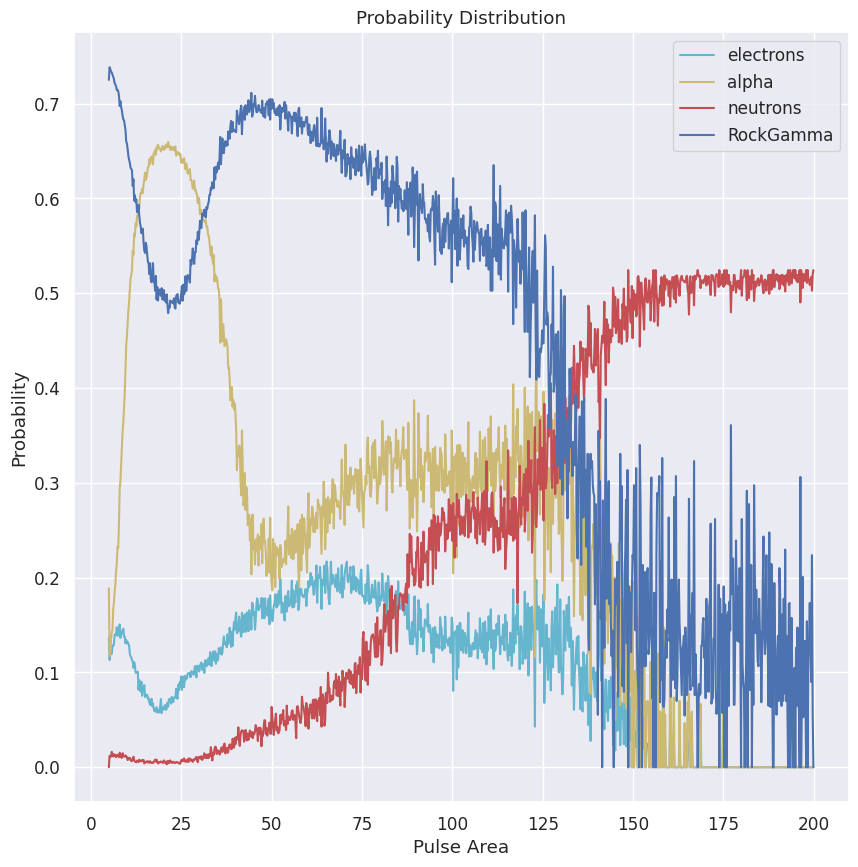

/tmp/ipykernel_766524/1128715918.py:69: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  pde_df.drop(pde_df.columns.difference(['Pulse Area','tag']), 1, inplace=True)
100%|██████████████████████████████| 708046/708046 [00:00<00:00, 3384554.21it/s]


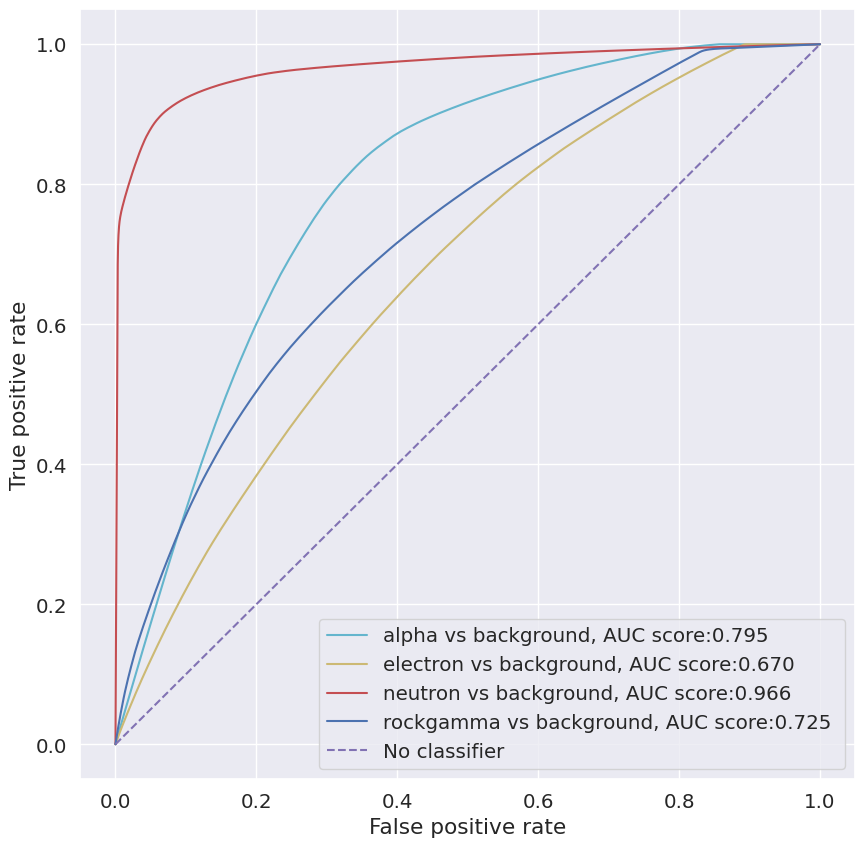

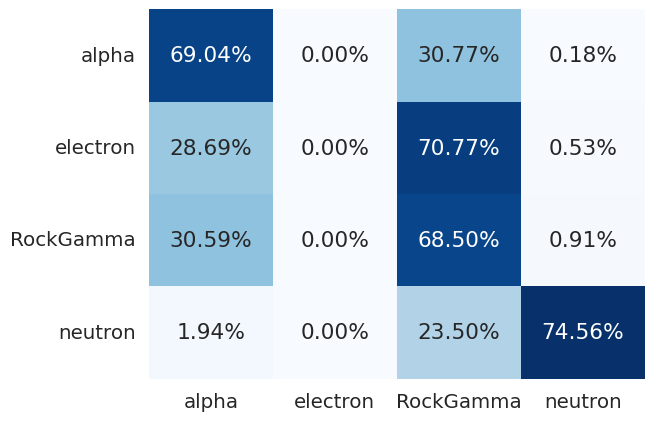

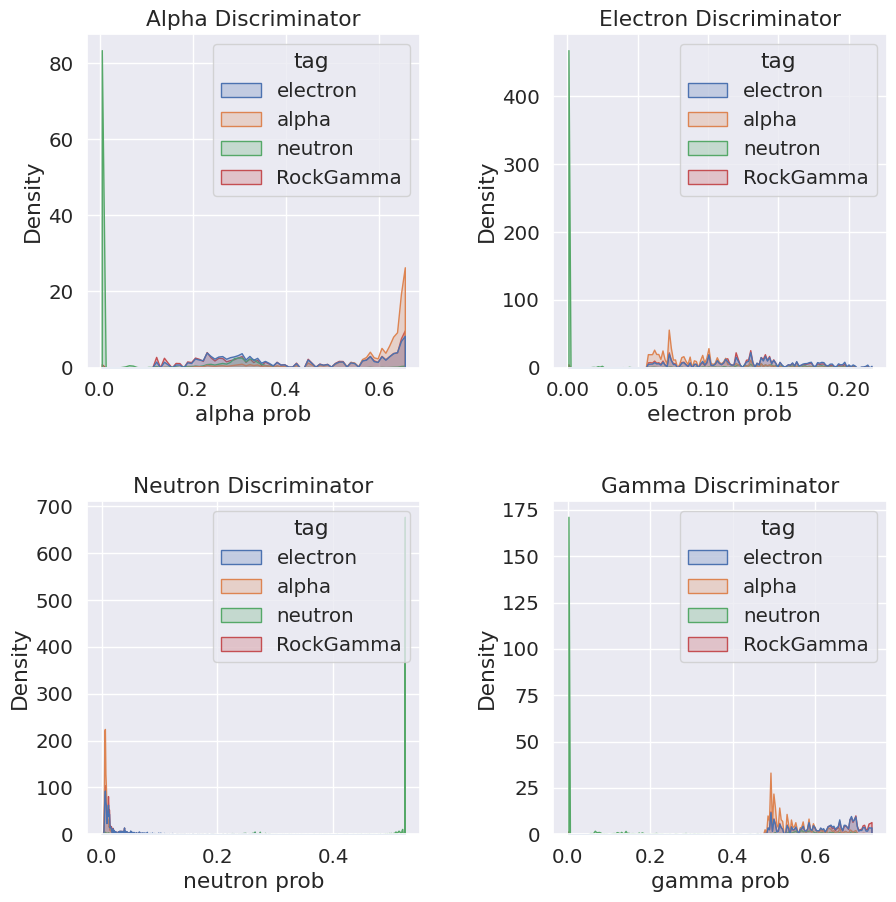

In [23]:
pde_metrics,Afpr, Atpr,Bfpr, Btpr,Nfpr, Ntpr,Rfpr, Rtpr=pde_run(electrons,alphas,neutron_data,rockgamma_data,decay_type)

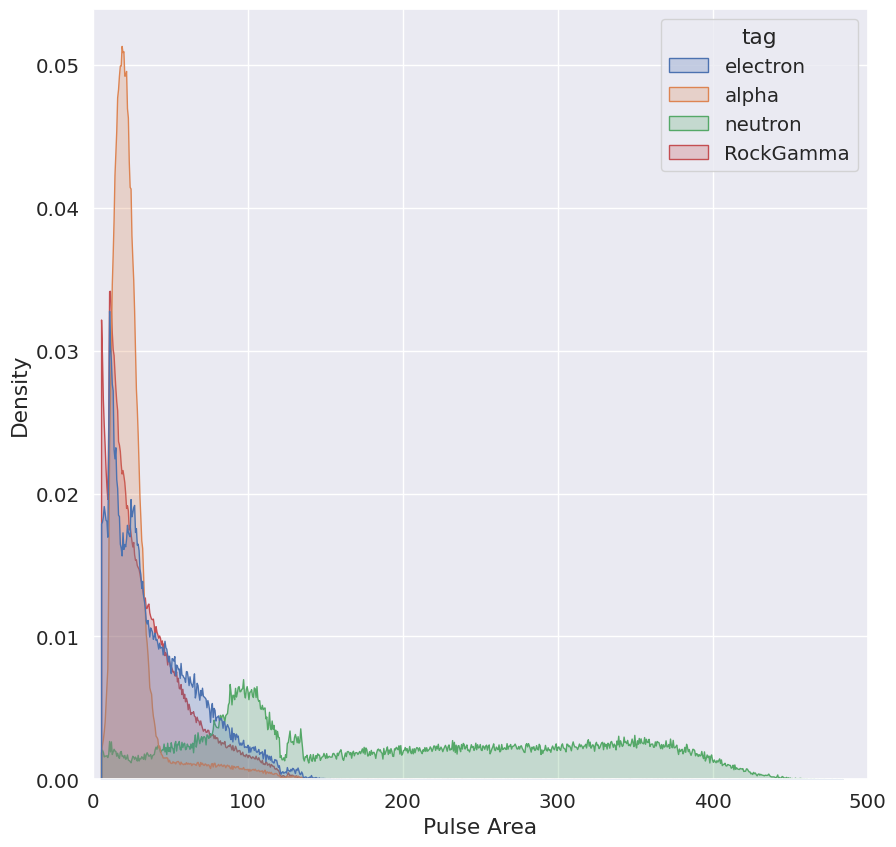

In [18]:
######################Visualisation for the cut method

#data1=(pd.DataFrame(cut_df[0]))
#data1['cut tag']='electrons'
#data2=(pd.DataFrame(cut_df[1]))
#data2['cut tag']='alpha'
#data3=(pd.DataFrame(cut_df[2]))
#data3['cut tag']='neutron'
#data4=(pd.DataFrame(cut_df[3]))
#data4['cut tag']='RockGamma'

#cut_df=pd.concat([data1,data2,data3,data4],ignore_index=True)

#cut_metrics['method']='cut'

plt.close()
plt.figure(figsize=(10,10))
sns.set(font_scale = 1.3)
sns.histplot(data=cut_df, x="Pulse Area",hue='tag', element="poly", common_norm=False, stat="density")
plt.xlim(0,500)
plt.show()

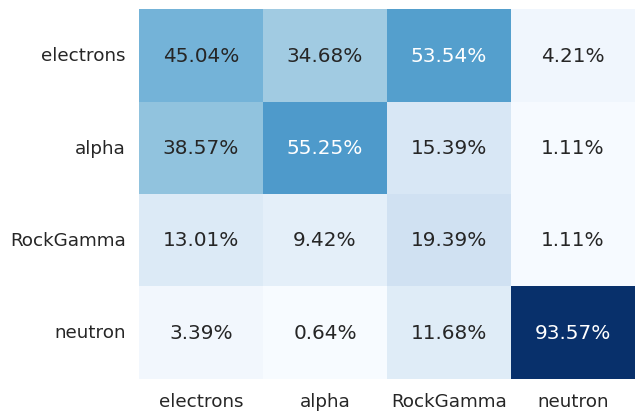

In [16]:
label_true =pd.get_dummies(data = cut_df['tag'])

label_pred =pd.get_dummies(data = cut_df['cut tag'])
cm=confusion_matrix(np.asarray(label_true).argmax(axis=1), np.asarray(label_pred).argmax(axis=1),normalize='pred')

categories = ['electrons','alpha','RockGamma','neutron']
sns.set(font_scale = 1.2)
sns.heatmap(cm,xticklabels=categories,yticklabels=categories, annot=True,fmt='.2%',cbar=False, cmap='Blues')
plt.show()

In [20]:
chains=pd.concat([Th232_chain,U238_chain],ignore_index=True)
NA_history,NA_labels_test,NA_proba=binary_run(decay_type,"neutron","RockGamma")
EA_history,EA_labels_test,EA_proba=binary_run(decay_type,"electron","alpha")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 90        
                                                                 
 dense_1 (Dense)             (None, 18)                180       
                                                                 
 dense_2 (Dense)             (None, 18)                342       
                                                                 
 dense_3 (Dense)             (None, 18)                342       
                                                                 
 dense_4 (Dense)             (None, 1)                 19        
                                                                 
Total params: 973
Trainable params: 973
Non-trainable params: 0
_________________________________________________________________


2022-04-21 12:42:28.779686: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/400
199/199 [==============================] - 1s 3ms/step - loss: 0.3306 - auc: 0.9303 - binary_accuracy: 0.8788 - val_loss: 0.2149 - val_auc: 0.9562 - val_binary_accuracy: 0.9229
Epoch 2/400
199/199 [==============================] - 0s 2ms/step - loss: 0.2465 - auc: 0.9566 - binary_accuracy: 0.9171 - val_loss: 0.2285 - val_auc: 0.9588 - val_binary_accuracy: 0.9181
Epoch 3/400
199/199 [==============================] - 0s 2ms/step - loss: 0.2423 - auc: 0.9583 - binary_accuracy: 0.9192 - val_loss: 0.2141 - val_auc: 0.9602 - val_binary_accuracy: 0.9232
Epoch 4/400
199/199 [==============================] - 0s 2ms/step - loss: 0.2407 - auc: 0.9590 - binary_accuracy: 0.9201 - val_loss: 0.2478 - val_auc: 0.9609 - val_binary_accuracy: 0.9118
Epoch 5/400
199/199 [==============================] - 0s 2ms/step - loss: 0.2380 - auc: 0.9599 - binary_accuracy: 0.9221 - val_loss: 0.2172 - val_auc: 0.9615 - val_binary_accuracy: 0.9241
Epoch 6/400
199/199 [==============================] - 

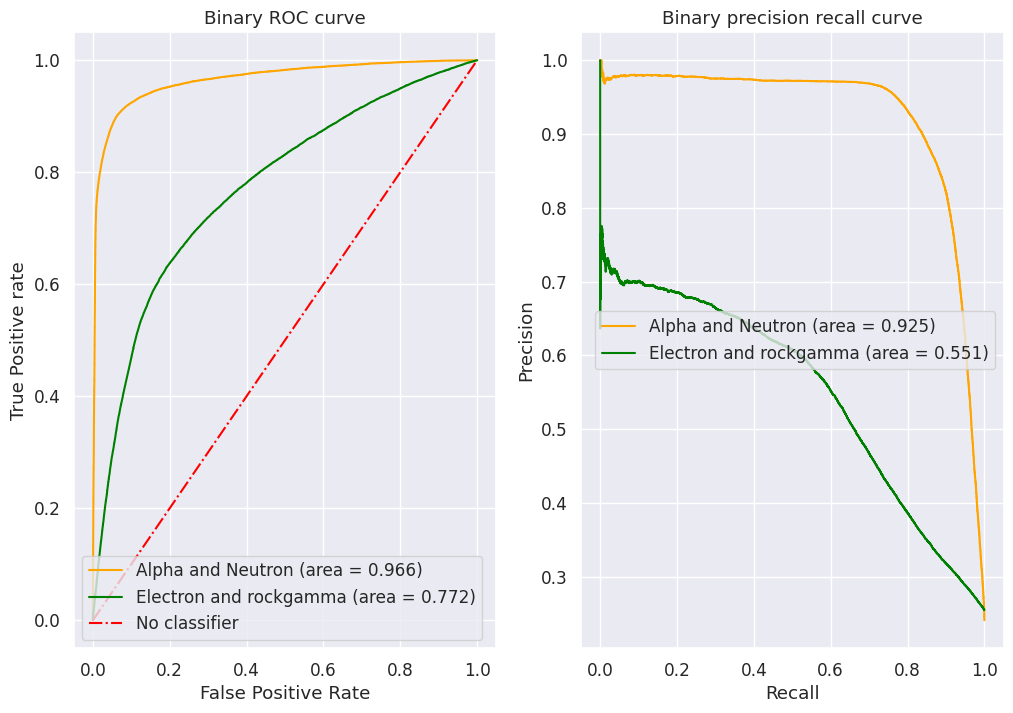

In [26]:
######################visualisation for binary classifier##########################  
NA_fpr, NA_tpr, NA_thresh = roc_curve(NA_labels_test, NA_proba, pos_label=1)
NA_prec, NA_recall,NA_recall_thresh = precision_recall_curve(NA_labels_test, NA_proba, pos_label=1)
NA_predictions = discriminator(NA_proba,0.5)
NA_confusion=confusion_matrix(NA_labels_test, NA_predictions)

NA_F1=(2*NA_recall*NA_prec)/(NA_recall+NA_prec)

EA_fpr, EA_tpr, EA_thresh = roc_curve(EA_labels_test, EA_proba, pos_label=1)
EA_prec, EA_recall,EA_recall_thresh = precision_recall_curve(EA_labels_test, EA_proba, pos_label=1)
EA_predictions = discriminator(EA_proba,0.5)
EA_confusion=confusion_matrix(EA_labels_test, EA_predictions)

EA_F1=(2*EA_recall*EA_prec)/(EA_recall+EA_prec)

sns.set(font_scale=1.1)

plt.close()

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
axes[0].plot(NA_fpr, NA_tpr,color='orange', label='Alpha and Neutron (area = {:.3f})'.format(auc(NA_fpr,NA_tpr)))
axes[0].plot(EA_fpr, EA_tpr,color='green', label='Electron and rockgamma (area = {:.3f})'.format(auc(EA_fpr,EA_tpr)))
axes[0].plot([0, 1], [0, 1],linestyle='dashdot',color='red', label='No classifier')
axes[0].set_title('Binary ROC curve')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive rate')
axes[0].legend(loc='best')

axes[1].plot(NA_recall, NA_prec,color='orange', label='Alpha and Neutron (area = {:.3f})'.format(auc(NA_recall,NA_prec)))
axes[1].plot(EA_recall, EA_prec,color='green', label='Electron and rockgamma (area = {:.3f})'.format(auc(EA_recall,EA_prec)))
axes[1].set_title('Binary precision recall curve')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend(loc='best')
plt.show()

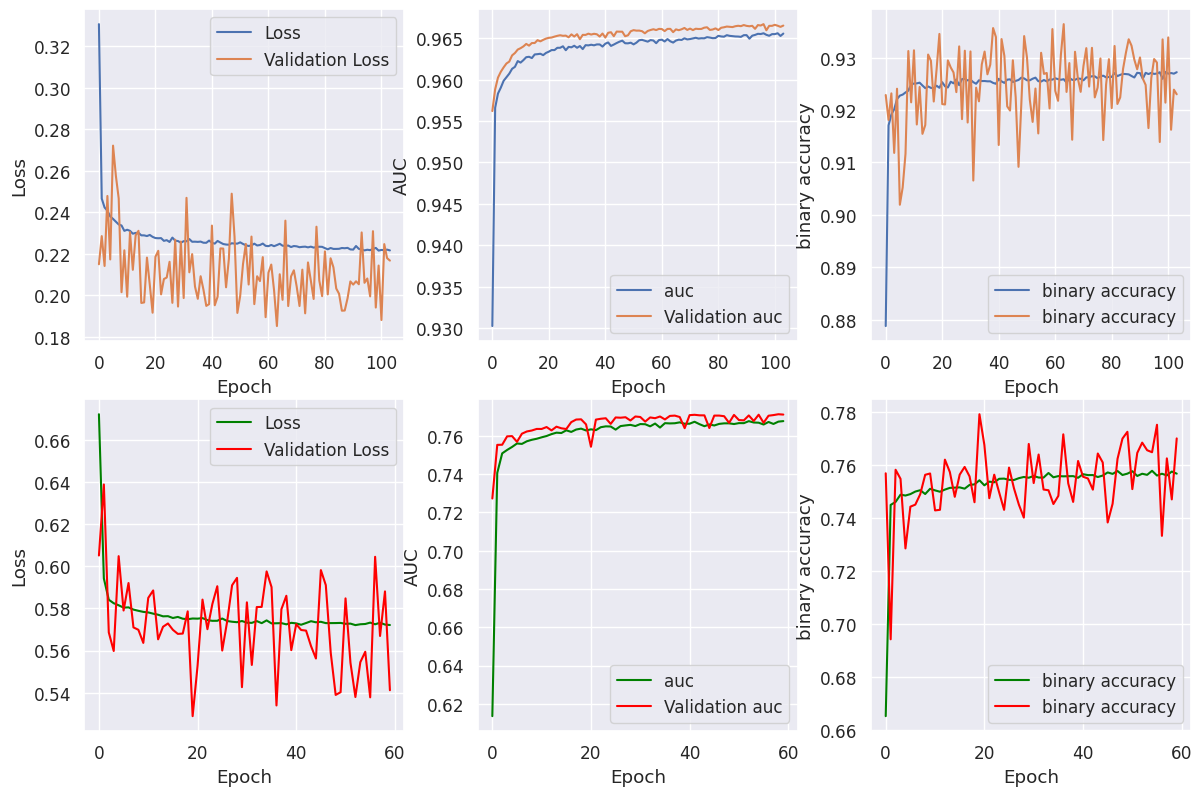

In [27]:
#learning history for binary classifer
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
fig.tight_layout()
axes[0,0].plot(NA_history.history['loss'],label='Loss')
axes[0,0].plot(NA_history.history['val_loss'],label='Validation Loss')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')

axes[0,0].legend(loc='best')



axes[0,1].plot(NA_history.history['auc'],label='auc')
axes[0,1].plot(NA_history.history['val_auc'],label='Validation auc')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('AUC')
axes[0,1].legend(loc='best')



axes[0,2].plot(NA_history.history['binary_accuracy'],label='binary accuracy')
axes[0,2].plot(NA_history.history['val_binary_accuracy'],label='binary accuracy')
axes[0,2].set_xlabel('Epoch')
axes[0,2].set_ylabel('binary accuracy')
axes[0,2].legend(loc='best')



axes[1,0].plot(EA_history.history['loss'],label='Loss',color='green')
axes[1,0].plot(EA_history.history['val_loss'],label='Validation Loss',color='red')
axes[1,0].set_xlabel('Epoch')
axes[1,0].set_ylabel('Loss')
axes[1,0].legend(loc='best')



axes[1,1].plot(EA_history.history['auc'],label='auc',color='green')
axes[1,1].plot(EA_history.history['val_auc'],label='Validation auc',color='red')
axes[1,1].set_xlabel('Epoch')
axes[1,1].set_ylabel('AUC')
axes[1,1].legend(loc='best')



axes[1,2].plot(EA_history.history['binary_accuracy'],label='binary accuracy',color='green')
axes[1,2].plot(EA_history.history['val_binary_accuracy'],label='binary accuracy',color='red')
axes[1,2].set_xlabel('Epoch')
axes[1,2].set_ylabel('binary accuracy')
axes[1,2].legend(loc='best')
plt.show()

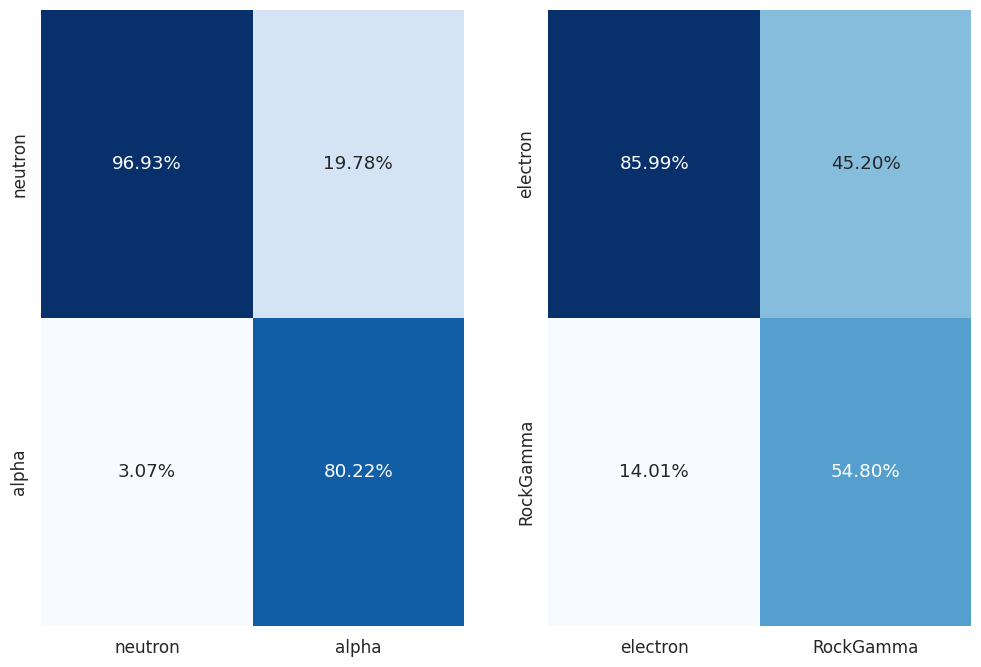

In [31]:
#confusion matrices for binary classifier
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

NA_cm=confusion_matrix(NA_labels_test,discriminator(NA_proba,0.5),normalize='pred')
categories = ['neutron','alpha']

sns.heatmap(ax=axes[0],data=NA_cm,xticklabels=categories,yticklabels=categories, annot=True,fmt='.2%',cbar=False, cmap='Blues')

EA_cm=confusion_matrix(EA_labels_test,discriminator(EA_proba,0.5),normalize='pred')
categories = ['electron','RockGamma']
sns.heatmap(ax=axes[1],data=EA_cm,xticklabels=categories,yticklabels=categories, annot=True,fmt='.2%',cbar=False, cmap='Blues')
plt.show()

NA_metrics=confusion_metrics(NA_confusion)
EA_metrics=confusion_metrics(EA_confusion)
columns={'accuracy' : [], 'recall' : [], 'precision' : [], 'F1 score' : [], 'specificity' : []}
BN_metrics=pd.DataFrame(np.asarray([NA_metrics,EA_metrics]),columns=columns)


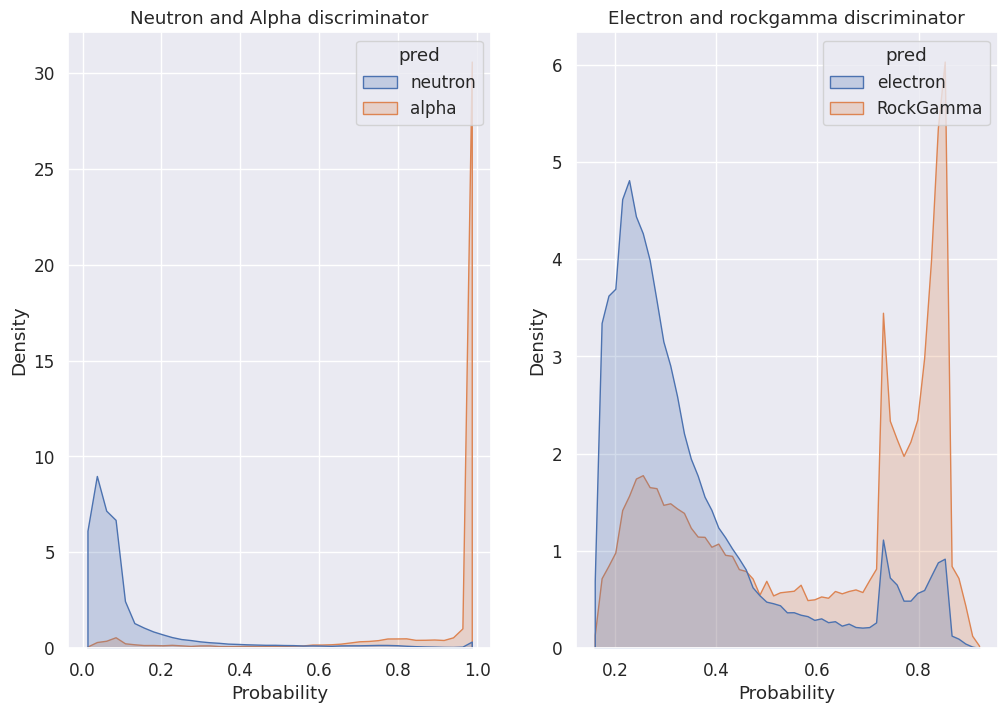

In [32]:
#discriminators for binary classifier
prob_col=['prob','true']
NA_data=pd.DataFrame([],columns=prob_col)
NA_data['prob']=NA_proba.tolist()
NA_data['true']=NA_labels_test.tolist()
NA_data=NA_data.explode(column=prob_col)
NA_data.loc[NA_data['true'] ==1, 'pred'] = 'alpha'
NA_data.loc[NA_data['true'] ==0, 'pred'] = 'neutron'


prob_col=['prob','true']
EA_data=pd.DataFrame([],columns=prob_col)
EA_data['prob']=EA_proba.tolist()
EA_data['true']=EA_labels_test.tolist()
EA_data=EA_data.explode(column=prob_col)
EA_data.loc[EA_data['true'] ==1, 'pred'] = 'RockGamma'
EA_data.loc[EA_data['true'] ==0, 'pred'] = 'electron'
plt.close()
fig, axes = plt.subplots(1, 2, figsize=(12, 8))

sns.histplot(ax=axes[0],data=NA_data, x="prob",hue='pred', element="poly", common_norm=False, stat="density")
axes[0].set_xlabel('Probability')
axes[0].set_title('Neutron and Alpha discriminator')
sns.histplot(ax=axes[1],data=EA_data, x="prob",hue='pred', element="poly", common_norm=False, stat="density")
axes[1].set_xlabel('Probability')
axes[1].set_title('Electron and rockgamma discriminator')
plt.show()

In [10]:
history, labels_test,proba=multiclass(decay_type)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 9)                 90        
                                                                 
 dense_1 (Dense)             (None, 18)                180       
                                                                 
 dense_2 (Dense)             (None, 18)                342       
                                                                 
 dense_3 (Dense)             (None, 18)                342       
                                                                 
 dense_4 (Dense)             (None, 4)                 76        
                                                                 
Total params: 1,030
Trainable params: 1,030
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400


2022-04-21 14:27:54.802488: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


604/604 [==============================] - 2s 2ms/step - loss: 0.9677 - auc: 0.8200 - categorical_accuracy: 0.5438 - val_loss: 0.9303 - val_auc: 0.8361 - val_categorical_accuracy: 0.5656
Epoch 2/400
604/604 [==============================] - 1s 2ms/step - loss: 0.9230 - auc: 0.8382 - categorical_accuracy: 0.5675 - val_loss: 0.9231 - val_auc: 0.8380 - val_categorical_accuracy: 0.5662
Epoch 3/400
604/604 [==============================] - 1s 2ms/step - loss: 0.9166 - auc: 0.8405 - categorical_accuracy: 0.5711 - val_loss: 0.9188 - val_auc: 0.8399 - val_categorical_accuracy: 0.5705
Epoch 4/400
604/604 [==============================] - 1s 2ms/step - loss: 0.9131 - auc: 0.8419 - categorical_accuracy: 0.5721 - val_loss: 0.9168 - val_auc: 0.8410 - val_categorical_accuracy: 0.5713
Epoch 5/400
604/604 [==============================] - 1s 2ms/step - loss: 0.9123 - auc: 0.8422 - categorical_accuracy: 0.5722 - val_loss: 0.9185 - val_auc: 0.8399 - val_categorical_accuracy: 0.5679
Epoch 6/400
604/6

/tmp/ipykernel_766524/3368170.py:19: RuntimeWarning: invalid value encountered in true_divide
  F1[i]=(2*recall[i]*prec[i])/(recall[i]+prec[i])
/tmp/ipykernel_766524/3368170.py:19: RuntimeWarning: invalid value encountered in true_divide
  F1[i]=(2*recall[i]*prec[i])/(recall[i]+prec[i])


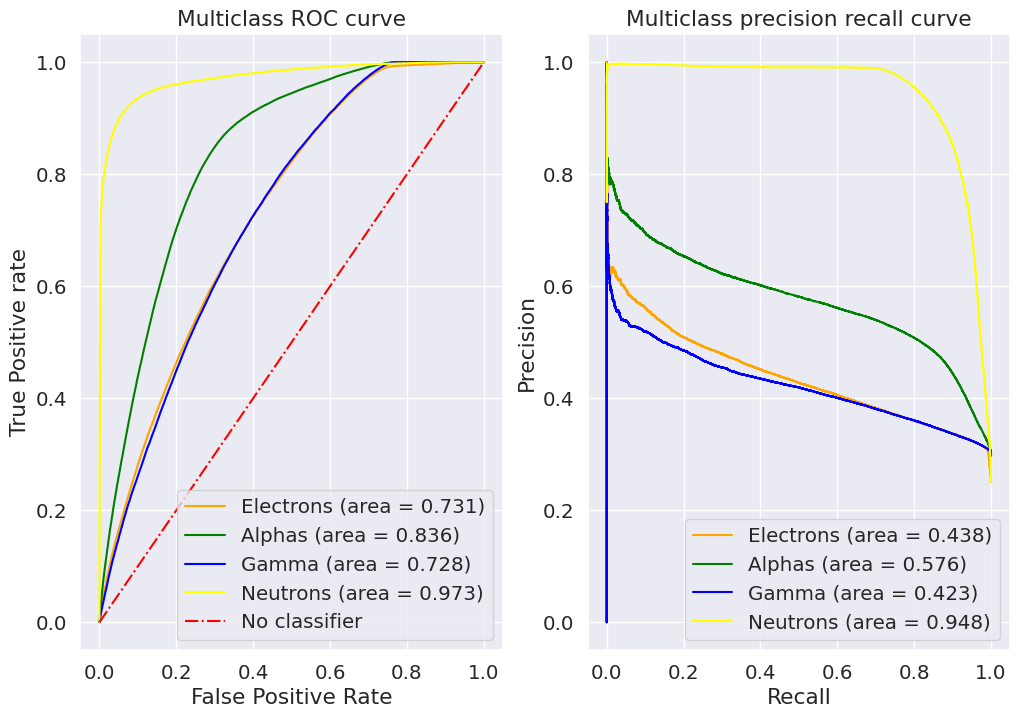

In [11]:
#visualisation for multiclass
fpr = {}
tpr = {}
thresh ={}
prec={}
recall={}
recall_thresh={}
confusion_list=[]
NN_metrics_list=[]
F1={}
n_class = 4
sample=["electron","alpha",'Gamma','neutron']
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(labels_test[:,i], proba[:,i], pos_label=1)
    prec[i], recall[i],recall_thresh[i] = precision_recall_curve(labels_test[:,i], proba[:,i], pos_label=1)
    predictions = discriminator(proba[:,i],0.5)
    confusion=confusion_matrix(labels_test[:,i], predictions)
    NN_metrics_list.append(confusion_metrics(confusion))
    F1[i]=(2*recall[i]*prec[i])/(recall[i]+prec[i])


plt.close()
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].plot(fpr[0], tpr[0],color='orange', label='Electrons (area = {:.3f})'.format(auc(fpr[0],tpr[0])))
ax[0].plot(fpr[1], tpr[1],color='green', label='Alphas (area = {:.3f})'.format(auc(fpr[1],tpr[1])))
ax[0].plot(fpr[2], tpr[2],color='blue', label='Gamma (area = {:.3f})'.format(auc(fpr[2],tpr[2])))
ax[0].plot(fpr[3], tpr[3],color='yellow', label='Neutrons (area = {:.3f})'.format(auc(fpr[3],tpr[3])))
ax[0].plot([0, 1], [0, 1],linestyle='dashdot',color='red', label='No classifier')
ax[0].set_title('Multiclass ROC curve')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive rate')
ax[0].legend(loc='best')



ax[1].plot(recall[0], prec[0],color='orange', label='Electrons (area = {:.3f})'.format(auc(recall[0],prec[0])))
ax[1].plot(recall[1], prec[1],color='green', label='Alphas (area = {:.3f})'.format(auc(recall[1],prec[1])))
ax[1].plot(recall[2], prec[2],color='blue', label='Gamma (area = {:.3f})'.format(auc(recall[2],prec[2])))
ax[1].plot(recall[3], prec[3],color='yellow', label='Neutrons (area = {:.3f})'.format(auc(recall[3],prec[3])))
ax[1].set_title('Multiclass precision recall curve')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].legend(loc='best')
plt.show()

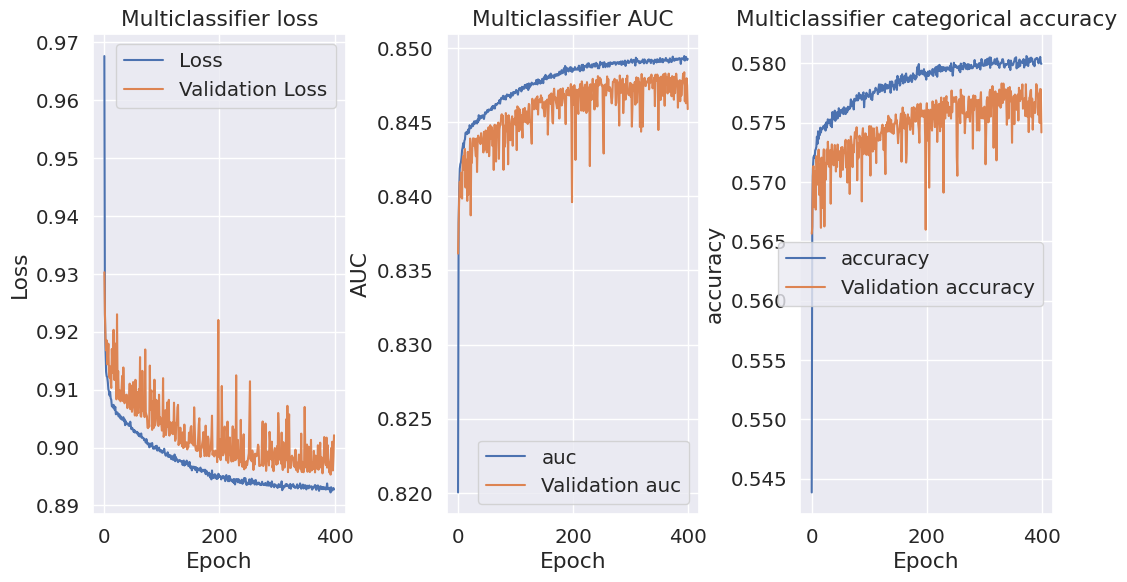

In [12]:
#learning history for multiclass
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].plot(history.history['loss'],label='Loss')
ax[0].plot(history.history['val_loss'],label='Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best')
ax[0].set_title("Multiclassifier loss")



ax[1].plot(history.history['auc'],label='auc')
ax[1].plot(history.history['val_auc'],label='Validation auc')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('AUC')
ax[1].legend(loc='best')
ax[1].set_title("Multiclassifier AUC")



ax[2].plot(history.history['categorical_accuracy'],label='accuracy')
ax[2].plot(history.history['val_categorical_accuracy'],label='Validation accuracy')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('accuracy')
ax[2].legend(loc='best')
ax[2].set_title("Multiclassifier categorical accuracy")

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

plt.show()

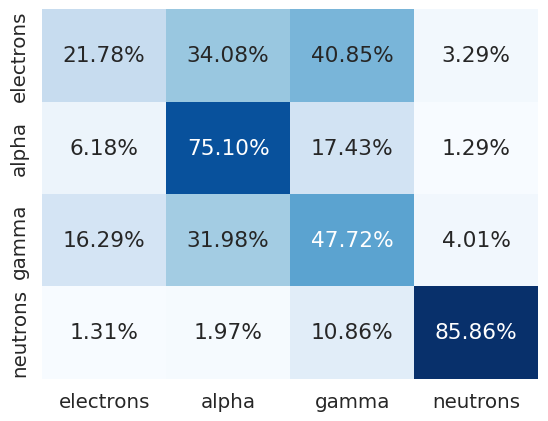

In [13]:
#confusion matrix for multiclass
cm=confusion_matrix(np.asarray(labels_test).argmax(axis=1), np.asarray(proba).argmax(axis=1),normalize='true')

categories = ['electrons','alpha','gamma','neutrons']
#cmn=cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm,xticklabels=categories,yticklabels=categories, annot=True,fmt='.2%',cbar=False, cmap='Blues')
plt.show()

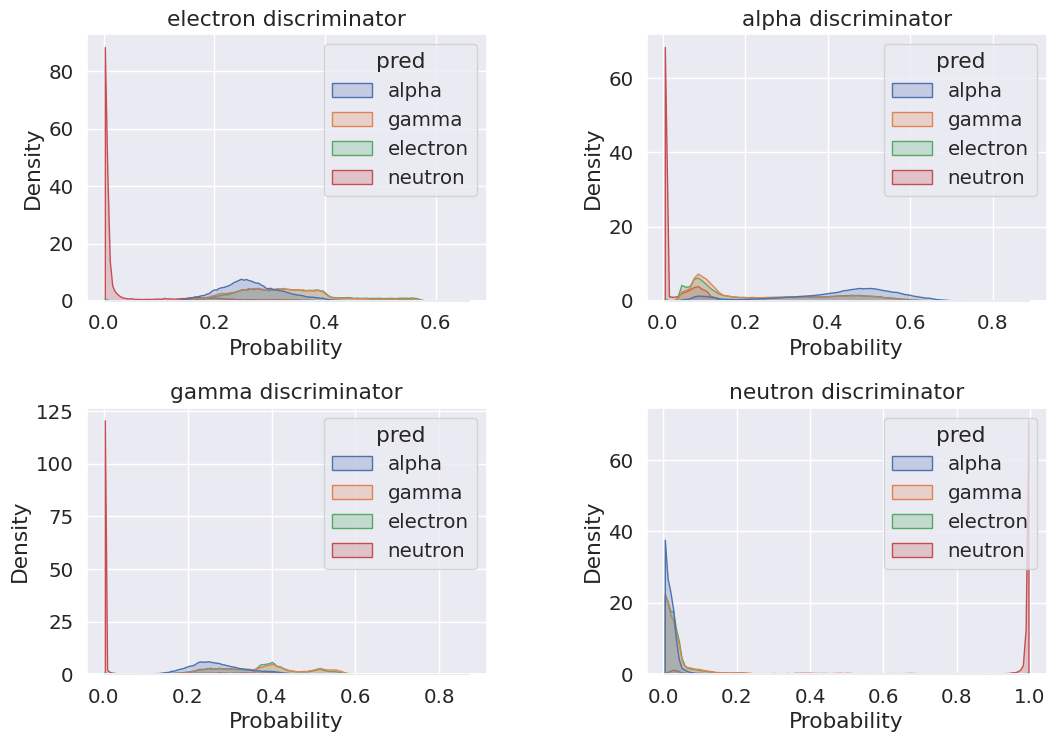

In [14]:
#discriminators for multiclass

prob_col=['prob','electron_true','alpha_true','gamma_true','neutron_true']


electron_data=pd.DataFrame([],columns=prob_col)
electron_data['prob']=(proba[:,0])
electron_data['electron_true']=(labels_test[:,0])
electron_data['alpha_true']=(labels_test[:,1])
electron_data['gamma_true']=(labels_test[:,2])
electron_data['neutron_true']=(labels_test[:,3])
electron_data.loc[electron_data['electron_true'] ==1, 'pred'] = 'electron'
electron_data.loc[electron_data['alpha_true'] ==1, 'pred'] = 'alpha'
electron_data.loc[electron_data['gamma_true'] ==1, 'pred'] = 'gamma'
electron_data.loc[electron_data['neutron_true'] ==1, 'pred'] = 'neutron'


alpha_data=pd.DataFrame([],columns=prob_col)
alpha_data['prob']=(proba[:,1])
alpha_data['electron_true']=(labels_test[:,0])
alpha_data['alpha_true']=(labels_test[:,1])
alpha_data['gamma_true']=(labels_test[:,2])
alpha_data['neutron_true']=(labels_test[:,3])
alpha_data.loc[alpha_data['electron_true'] ==1, 'pred'] = 'electron'
alpha_data.loc[alpha_data['alpha_true'] ==1, 'pred'] = 'alpha'
alpha_data.loc[alpha_data['gamma_true'] ==1, 'pred'] = 'gamma'
alpha_data.loc[alpha_data['neutron_true'] ==1, 'pred'] = 'neutron'

gamma_data=pd.DataFrame([],columns=prob_col)
gamma_data['prob']=(proba[:,2])
gamma_data['electron_true']=(labels_test[:,0])
gamma_data['alpha_true']=(labels_test[:,1])
gamma_data['gamma_true']=(labels_test[:,2])
gamma_data['neutron_true']=(labels_test[:,3])
gamma_data.loc[gamma_data['electron_true'] ==1, 'pred'] = 'electron'
gamma_data.loc[gamma_data['alpha_true'] ==1, 'pred'] = 'alpha'
gamma_data.loc[gamma_data['gamma_true'] ==1, 'pred'] = 'gamma'
gamma_data.loc[gamma_data['neutron_true'] ==1, 'pred'] = 'neutron'

neutron_data=pd.DataFrame([],columns=prob_col)
neutron_data['prob']=(proba[:,3])
neutron_data['electron_true']=(labels_test[:,0])
neutron_data['alpha_true']=(labels_test[:,1])
neutron_data['gamma_true']=(labels_test[:,2])
neutron_data['neutron_true']=(labels_test[:,3])
neutron_data.loc[neutron_data['electron_true'] ==1, 'pred'] = 'electron'
neutron_data.loc[neutron_data['alpha_true'] ==1, 'pred'] = 'alpha'
neutron_data.loc[neutron_data['gamma_true'] ==1, 'pred'] = 'gamma'
neutron_data.loc[neutron_data['neutron_true'] ==1, 'pred'] = 'neutron'




plt.close()
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(ax=ax[0,0],data=electron_data, x="prob",hue='pred', element="poly", common_norm=False, stat="density")
ax[0,0].set_xlabel('Probability')
ax[0,0].set_title('electron discriminator')


sns.histplot(ax=ax[0,1],data=alpha_data, x="prob",hue='pred', element="poly", common_norm=False, stat="density")
ax[0,1].set_xlabel('Probability')
ax[0,1].set_title('alpha discriminator')


sns.histplot(ax=ax[1,0],data=gamma_data, x="prob",hue='pred', element="poly", common_norm=False, stat="density")
ax[1,0].set_xlabel('Probability')
ax[1,0].set_title('gamma discriminator')


sns.histplot(ax=ax[1,1],data=neutron_data, x="prob",hue='pred', element="poly", common_norm=False, stat="density")
ax[1,1].set_xlabel('Probability')
ax[1,1].set_title('neutron discriminator')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

In [38]:
#comparing all metrics
columns={'accuracy' : [], 'recall' : [], 'precision' : [], 'F1 score' : [], 'specificity' : []}
NN_metrics=pd.DataFrame(np.asarray(NN_metrics_list),columns=columns)
NN_metrics=NN_metrics.round(decimals = 5)
NN_metrics['method']='multiclassifier'
NN_metrics['sample']=['electron','alpha','RockGamma','neutron']
cut_metrics['method']='cut'
comparison_metrics=pd.concat([NN_metrics,pde_metrics,cut_metrics]).reset_index()
comparison_metrics

NameError: name 'pde_metrics' is not defined

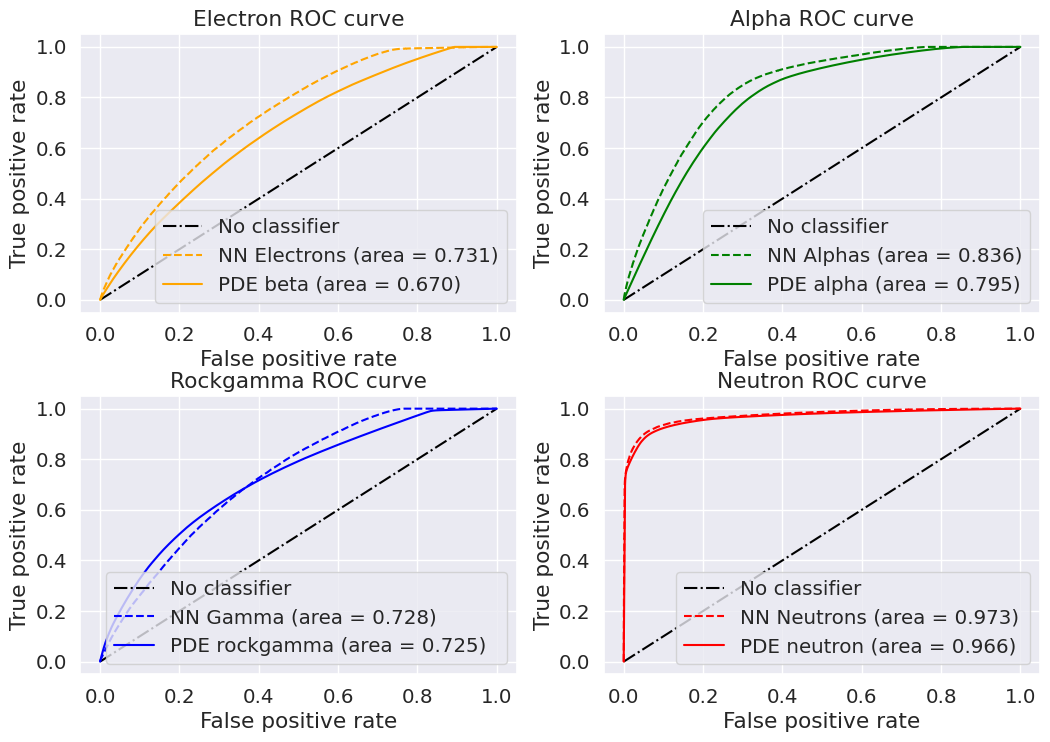

In [21]:
#comparing 

plt.close()
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax[0,0].plot([0, 1], [0, 1],linestyle='dashdot',color='black', label='No classifier')
ax[0,0].plot(fpr[0], tpr[0], linestyle='--',color='orange', label='NN Electrons (area = {:.3f})'.format(auc(fpr[0],tpr[0])))
ax[0,0].plot(Bfpr,Btpr,label='PDE beta (area = {:.3f})' .format(auc(Bfpr,Btpr)),color = 'orange')
ax[0,0].set_xlabel('False positive rate')
ax[0,0].set_ylabel('True positive rate')
ax[0,0].set_title('Electron ROC curve')
ax[0,0].legend(loc='best')


ax[0,1].plot([0, 1], [0, 1],linestyle='dashdot',color='black', label='No classifier')
ax[0,1].plot(fpr[1], tpr[1], linestyle='--',color='green', label='NN Alphas (area = {:.3f})'.format(auc(fpr[1],tpr[1])))
ax[0,1].plot(Afpr,Atpr,label='PDE alpha (area = {:.3f})' .format(auc(Afpr,Atpr)), color = 'green')
ax[0,1].set_xlabel('False positive rate')
ax[0,1].set_ylabel('True positive rate')
ax[0,1].set_title('Alpha ROC curve')
ax[0,1].legend(loc='best')

ax[1,0].plot([0, 1], [0, 1],linestyle='dashdot',color='black', label='No classifier')
ax[1,0].plot(fpr[2], tpr[2], linestyle='--',color='blue', label='NN Gamma (area = {:.3f})'.format(auc(fpr[2],tpr[2])))
ax[1,0].plot(Rfpr,Rtpr,label='PDE rockgamma (area = {:.3f})  ' .format(auc(Rfpr,Rtpr)),color = 'blue')
ax[1,0].set_xlabel('False positive rate')
ax[1,0].set_ylabel('True positive rate')
ax[1,0].set_title('Rockgamma ROC curve')
ax[1,0].legend(loc='best')

ax[1,1].plot([0, 1], [0, 1],linestyle='dashdot',color='black', label='No classifier')
ax[1,1].plot(fpr[3], tpr[3], linestyle='--',color='red', label='NN Neutrons (area = {:.3f})'.format(auc(fpr[3],tpr[3])))
ax[1,1].plot(Nfpr,Ntpr,label='PDE neutron (area = {:.3f}) ' .format(auc(Nfpr,Ntpr)),color = 'red')
ax[1,1].set_xlabel('False positive rate')
ax[1,1].set_ylabel('True positive rate')
ax[1,1].set_title('Neutron ROC curve')
ax[1,1].legend(loc='best')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.3)
plt.show()
